In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

import sys; sys.path.insert(0, '../')

from laplace.baselaplace import FullLaplace, FunctionalLaplace
from tests.utils import toy_model, toy_multivariate_regression_dataset
from laplace.curvature.backpack import BackPackGP

In [74]:
torch.manual_seed(711)

## 0) utils

In [6]:
# modifed test from test_functional_laplace.py (return statements instead of assert statements)
def test_gp_equivalence_regression_multivariate(d=10, independent_gp_kernels=False, true_sigma_noise=0.1):
    X_train, y_train, train_loader, X_test = toy_multivariate_regression_dataset(sigma=true_sigma_noise,
                                                                                 d_input=d,
                                                                                 batch_size=60)
    model = toy_model(train_loader, in_dim=d, out_dim=d)

    full_la = FullLaplace(model, 'regression', sigma_noise=true_sigma_noise, prior_precision=2.0)
    functional_gp_la = FunctionalLaplace(model, 'regression', M=len(X_train),
                                         sigma_noise=true_sigma_noise, 
                                         independent_gp_kernels=independent_gp_kernels, prior_precision=2.0)
    full_la.fit(train_loader)
    functional_gp_la.fit(train_loader)

    f_mu_full, f_var_full = full_la(X_test)
    f_mu_gp, f_var_gp = functional_gp_la(X_test)

    f_mu_full = f_mu_full.squeeze().detach().cpu().numpy()
    f_var_full = f_var_full.squeeze().detach().cpu().numpy()
    f_mu_gp = f_mu_gp.squeeze().detach().cpu().numpy()
    f_var_gp = f_var_gp.squeeze().detach().cpu().numpy()

    assert np.allclose(f_mu_full, f_mu_gp)
    # if float64 is used instead of float32, one can use atol=1e-10 in assert below
    # assert np.allclose(f_var_full, f_var_gp, atol=1e-2)
    return f_var_full, f_var_gp

In [73]:
def evaluate_config(d_min, d_max, independent_gp_kernels):
    var_dict = {}
    time_dict = {}
    for d in range(d_min, d_max + 1):
        start = time.time()
        f_var_full, f_var_gp = test_gp_equivalence_regression_multivariate(d=d, 
                                                                           independent_gp_kernels=independent_gp_kernels)
        end = time.time()
        var_dict[d] = (f_var_full, f_var_gp)
        time_dict[d] = round(end - start, 2)
        
    for d, f_var in var_dict.items():
        
        if d > 1 and independent_gp_kernels: # can only compare diagonals
            diffs = np.abs(np.diagonal(f_var[0], axis1=1, axis2=2) - f_var[1])
        else:
            diffs = np.abs(f_var[0] - f_var[1])
        print(f"{d}: max abs diff {np.max(diffs):.4f}, mean abs diff {np.mean(diffs):.4f}, elapsed time {time_dict[d]}")
        
    return var_dict, time_dict

In [145]:
def get_K_MM(d, true_sigma_noise=0.1):
    X_train, y_train, train_loader, X_test = toy_multivariate_regression_dataset(sigma=true_sigma_noise,
                                                                                 d_input=d,
                                                                                 batch_size=60)
    model = toy_model(train_loader, in_dim=d, out_dim=d)
    functional_gp_la = FunctionalLaplace(model, 'regression', M=len(X_train),
                                         sigma_noise=true_sigma_noise, 
                                         independent_gp_kernels=False, prior_precision=2.0)
    functional_gp_la.fit(train_loader)
    K_MM = functional_gp_la.K_MM.detach().cpu().numpy()
    return K_MM

In [146]:
def get_jacobians(d, true_sigma_noise=0.1):
    X_train, y_train, train_loader, X_test = toy_multivariate_regression_dataset(sigma=true_sigma_noise,
                                                                                 d_input=d,
                                                                                 batch_size=60)
    model = toy_model(train_loader, in_dim=d, out_dim=d)
    
    setattr(model, 'output_size', d)
    backend = BackPackGP(model, likelihood="regression")
    
    jacobians = []
    for batch in train_loader:
        X, y = batch
        Js, f = backend.jacobians(model, X)
        jacobians.append(Js)
        
    jacobians = torch.cat(jacobians, dim=0)
    return jacobians

## 1) Full kernel

`independent_gp_kernels=False`

In [75]:
var_dict_full, time_dict_full = evaluate_config(1, 10, False)

1: max abs diff 0.0011, mean abs diff 0.0001, elapsed time 1.16
2: max abs diff 0.0016, mean abs diff 0.0001, elapsed time 1.4
3: max abs diff 0.0015, mean abs diff 0.0001, elapsed time 1.78
4: max abs diff 0.0030, mean abs diff 0.0001, elapsed time 2.57
5: max abs diff 0.0012, mean abs diff 0.0001, elapsed time 3.86
6: max abs diff 0.0014, mean abs diff 0.0001, elapsed time 5.59
7: max abs diff 0.0011, mean abs diff 0.0000, elapsed time 7.37
8: max abs diff 0.0008, mean abs diff 0.0000, elapsed time 10.12
9: max abs diff 0.0010, mean abs diff 0.0000, elapsed time 14.33
10: max abs diff 0.0029, mean abs diff 0.0000, elapsed time 18.29


## 2) Block-diagonal kernel

`independent_gp_kernels=True`

In [76]:
var_dict_block_diagonal, time_dict_block_diagonal = evaluate_config(1, 10, True)

1: max abs diff 0.0011, mean abs diff 0.0001, elapsed time 1.11
2: max abs diff 0.1224, mean abs diff 0.0066, elapsed time 1.22
3: max abs diff 0.5604, mean abs diff 0.0413, elapsed time 1.24
4: max abs diff 2.1054, mean abs diff 0.1937, elapsed time 1.52
5: max abs diff 2.6013, mean abs diff 0.4316, elapsed time 1.44
6: max abs diff 5.6491, mean abs diff 1.1871, elapsed time 1.64
7: max abs diff 22.6305, mean abs diff 3.1263, elapsed time 1.78
8: max abs diff 21.7142, mean abs diff 4.3904, elapsed time 1.89
9: max abs diff 37.7440, mean abs diff 6.1576, elapsed time 2.19
10: max abs diff 45.3835, mean abs diff 8.5579, elapsed time 2.23


## 3) Comparison

#### 3.1 Time

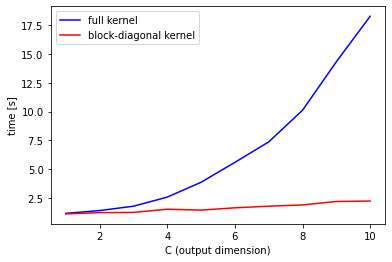

In [78]:
plt.plot(time_dict_full.keys(), time_dict_full.values(), 
         color="blue", label="full kernel")
plt.plot(time_dict_block_diagonal.keys(), time_dict_block_diagonal.values(), 
         color="red", label="block-diagonal kernel")
plt.legend(loc="best")
plt.ylabel("time [s]")
plt.xlabel("C (output dimension)")
plt.show()

#### 3.2 Max absolute difference to FullLaplace

In [79]:
diffs_full = [np.max(np.abs(f_var[0] - f_var[1])) for _, f_var in var_dict_full.items()]

In [80]:
diffs_block_diagonal = []
for d, f_var in var_dict_block_diagonal.items():
    if d > 1:
        diffs_block_diagonal.append(round(np.max(np.abs(np.diagonal(f_var[0], axis1=1, axis2=2) - f_var[1])), 4))
    else:
        diffs_block_diagonal.append(round(np.max(np.abs(f_var[0] - f_var[1])), 4))

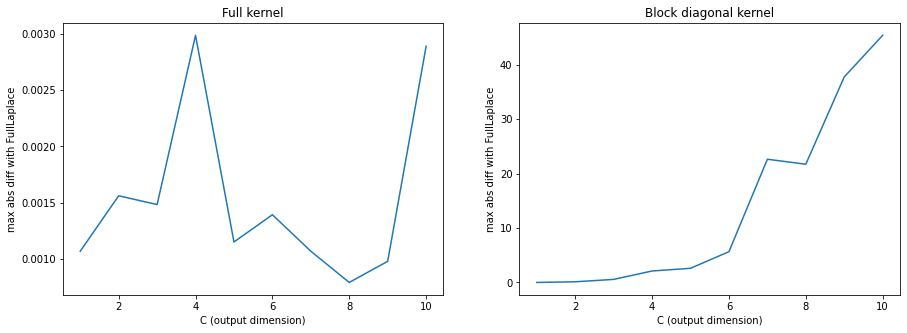

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(var_dict_full.keys(), diffs_full)
axs[0].set_title("Full kernel")
axs[1].plot(var_dict_block_diagonal.keys(), diffs_block_diagonal)
axs[1].set_title("Block diagonal kernel")

for ax in axs.flat:
    ax.set(xlabel='C (output dimension)', ylabel='max abs diff with FullLaplace')
plt.show()

## 4) Closer look at Block-Diagonal kernel

`independent_gp_kernels=True`

In [85]:
for d, f_var in var_dict_block_diagonal.items():
    # f_var_gp - f_var_full (no absolute values here)
    if d > 1:
        diffs = f_var[1] - np.diagonal(f_var[0], axis1=1, axis2=2)
    else:
        diffs = f_var[1] - f_var[0]
        
    print(f"{d}: min difference between f_var_gp and f_var_full {np.min(diffs):.4f}")

1: min difference between f_var_gp and f_var_full -0.0000
2: min difference between f_var_gp and f_var_full 0.0000
3: min difference between f_var_gp and f_var_full 0.0003
4: min difference between f_var_gp and f_var_full 0.0029
5: min difference between f_var_gp and f_var_full 0.0101
6: min difference between f_var_gp and f_var_full 0.0586
7: min difference between f_var_gp and f_var_full 0.1788
8: min difference between f_var_gp and f_var_full 0.5433
9: min difference between f_var_gp and f_var_full 0.3632
10: min difference between f_var_gp and f_var_full 1.0527


We see that with `independent_gp_kernels=True` we **always overestimate the uncertainty compared to FullLaplace** (or compared to FunctionalLaplace with `independent_gp_kernels=False`)

Look at $K_{MM}$:

In [123]:
K_MM = get_K_MM(10)

In [124]:
K_MM.shape

(1500, 1500)

In [134]:
K_MM = K_MM.reshape(-1)

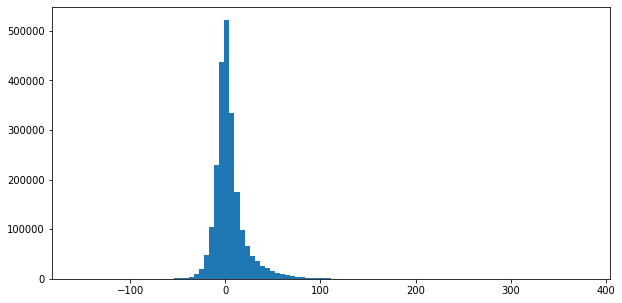

In [144]:
plt.figure(figsize=(10, 5))
plt.hist(K_MM, bins=100);

In [136]:
K_MM.mean()

4.4573107

In [138]:
np.median(K_MM)

1.5327489

In [141]:
(K_MM > 0).sum() / len(K_MM)

0.5696773333333334